* [The course](https://www.coursera.org/learn/introduction-to-pymc3/home)
* [The course material](https://sjster.github.io/introduction_to_computational_statistics/docs/Production/PyMC3.html)

# Logistic Regression

While everything we ahve seen so far involved regression, the saame ideas can be applied to a classification task as well. We use the logistic regression model to perform this classification here. The name 'regression' is due to the fact that the model outputs class probabilities as numbers which is then converted into classes using a decision boundary. There are many ways to select an appropriate decision boundary, a few of which are covered in Course 1 and Course 2.

## Inverse Link function

At this point it is a good idea to bring up the concept of a inverse link function, which takes the form

$$ \theta = f(\alpha + \beta x) $$

Here f is called the inverse link function, the term inverse refers to the fact that the function is applied to right hand side of the equation. 
In a linear regression, the inverse link function is the identity function. In the case of a linear regression model, the value $'y'$ at any point $'x'$ is modeled as the mean of a Gaussian distribution centered at the point $(x,y)$. Now think about the scenario where this is not appropriately modeled using a Gaussian. 

A classification problem is a perfect example of such a scenario where the discrete classes are not modeled well as a Gaussian and hence we can't use this distribution to model the mean of those classes.
As a result, we would like to convert the output of $\alpha + \beta x$ to some other range of values that are more appropriate to the problem being modeled, which is what the link function intends to do.


## Logistic function

The logistic function is defined as the function

$$ logistic(x) = \frac{1}{1 + exp(-x)} $$

This is also called the sigmoid function and it restricts the value of the output to the range $[0, 1]$.

Text(0, 0.5, 'logistic(x)')

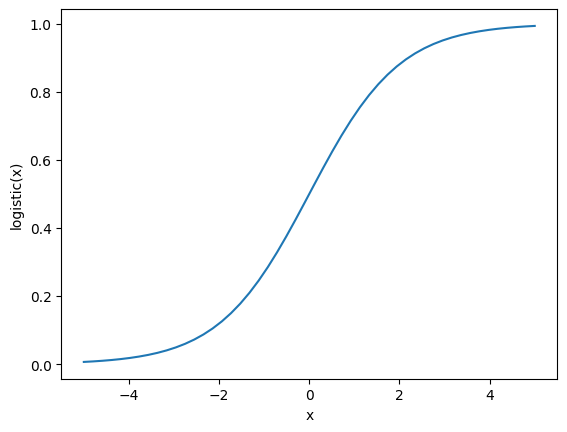

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5,5)
plt.plot(x, 1 / (1 + np.exp(-x)))
plt.xlabel('x')
plt.ylabel('logistic(x)')

## Example using the Iris Data

The simplest example using a logistic regression model is one that can be used to identify two classes. If you are given a set of independent variables that are features which correspond to an output dependent variable that is a class, you can build a model to learn the relationship between the features and the output classes. This is done with the help of the logistic function which acts as the inverse link function to relate the features to the output class.

$$ \theta = logistic(\alpha + \beta x)$$

If it is a two-class problem (binary classification), the output variable can be represented by a Bernoulli distribution.

$$ y \sim Bern(\theta)$$

The mean parameter $\theta$ is now given by the regression equation $logistic(\alpha + \beta x)$. In regular linear regression, this parameter was drawn from a Gaussian distribution.
In the case of the coin-flip example the data likelihood was represented by a Bernoulli distribution, (the parameter $\theta$ was drawn from a Beta prior distribution there), similarly we have output classes associated with every observation here.


We load the iris data from scikit learn and

* Plot the distribution of the three classes for two of the features.
* We also perform a pairplot to visualize the correlation of each feature with every other feature. The diagonal of this plot shows the distribution of the three classes for that feature.
* Correlation plot of just the features. This can be visually cleaner and cognitively simpler to comprehend.

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


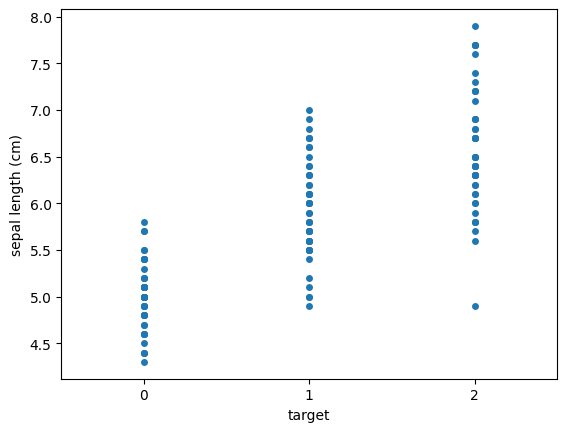

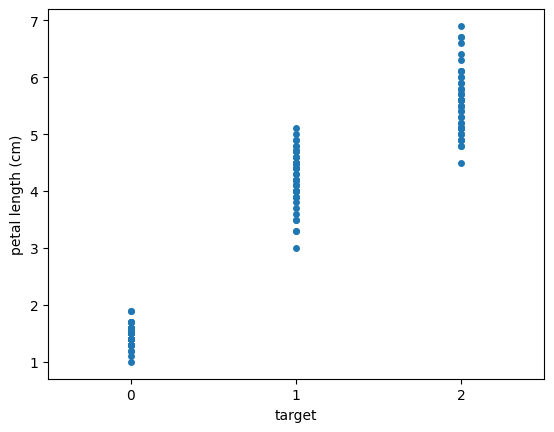

<Figure size 640x480 with 0 Axes>

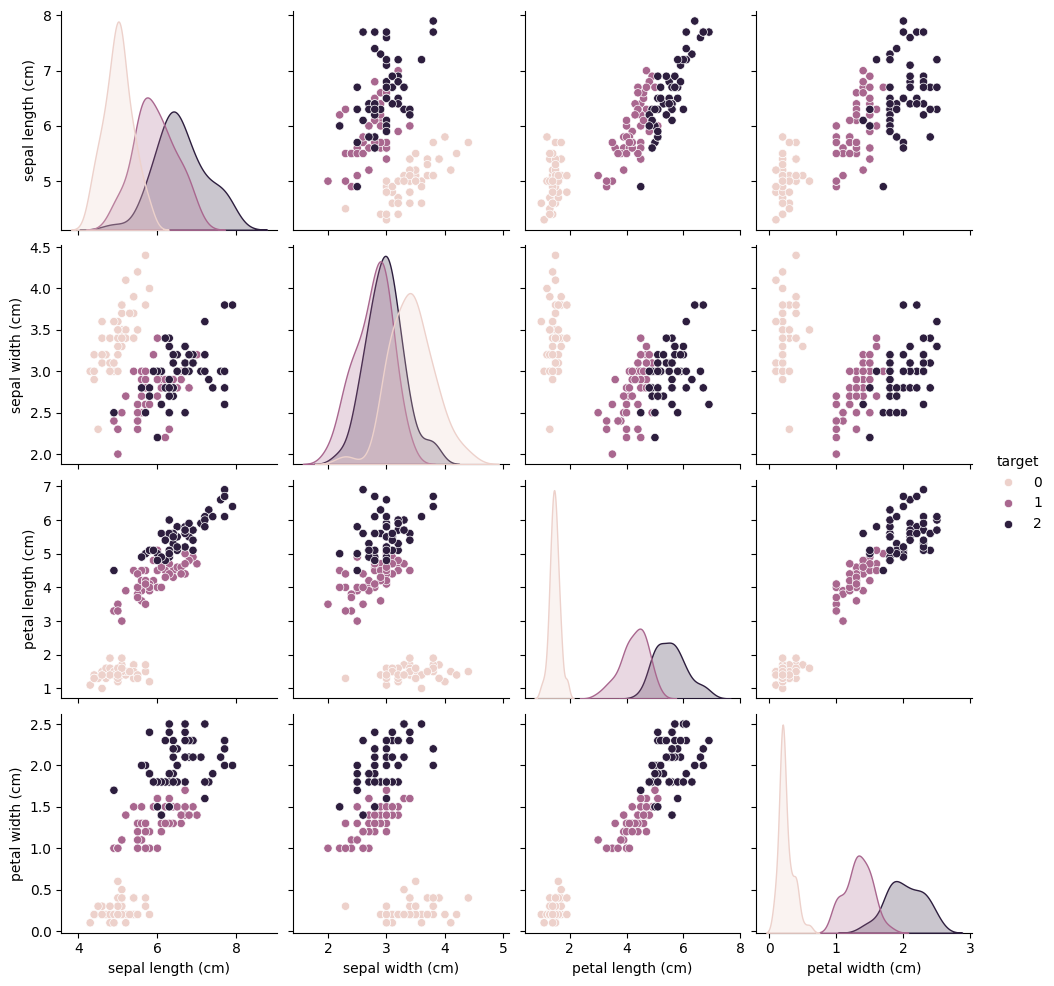

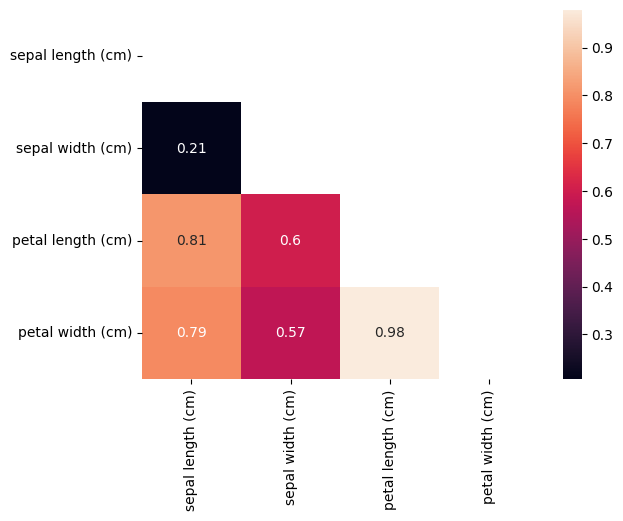

In [4]:
import pymc3 as pm
import sklearn
import numpy as np
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from sklearn import datasets

# Load the iris dataset
df = datasets.load_iris()
iris_data = pd.DataFrame(df['data'], columns=df['feature_names'])
iris_data['target'] = df['target']

# Strip plot 
seaborn.stripplot(x='target', y='sepal length (cm)', data=iris_data, jitter=False)
plt.figure()
seaborn.stripplot(x='target', y='petal length (cm)', data=iris_data, jitter=False)
plt.figure()
seaborn.pairplot(iris_data, hue='target', diag_kind='kde')
plt.figure()

# Correlation matrix
corr = iris_data.query("target == (0,1)").loc[:, iris_data.columns != 'target'].corr() 
mask = np.tri(*corr.shape).T 
seaborn.heatmap(corr.abs(), mask=mask, annot=True)
plt.show()

* You would notice that some of the variables have a high degree of correlation from the correlation plot.
    * One approach is to eliminate one of he correlated variables.
    * The second option is to mean-center and use a weakly-informative prior such as a Students t-distribution for all variables that are not binary.

    The scale parameter can be adjusted for the range of expected values for these variables and the normality parameter is recommended to be between 3 and 7 (source Andrew Gelman and the Stan team).

In [5]:
df['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

## Inference

We use a single feature, the sepal length, to learn a decision boundary between the first two classes in the iris data (0, 1).

In this case, the decision boundary is defined to be the value of ‘x’ when ‘y’ = 0.5. We won’t go over the derivation here, but this turns out to be −α/β
. However, this value was chosen under the assumption that the midpoint of the class values are a good candidate for separating the classes, but this does not have to be the case.


In [6]:
# Select the first two classes for a binary classification problem
# and the sepal length feature
df = iris_data.query("target == (0,1)")
y_0 = df.target
x_n = 'sepal length (cm)' 
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


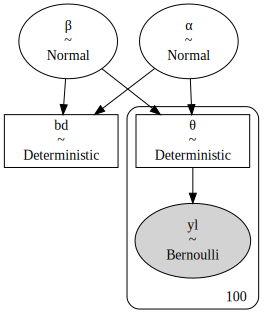

In [7]:
import pymc3 as pm
import arviz as az

with pm.Model() as model_0:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    μ = α + pm.math.dot(x_c, β)    
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)
    yl = pm.Bernoulli('yl', p=θ, observed=y_0)
    trace_0 = pm.sample(1000)

pm.model_to_graphviz(model_0)

In [8]:
az.summary(trace_0, var_names=["α","β","bd"])

Got error No model on context stack. trying to find log_likelihood in translation.


/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.311,0.343,-0.349,0.955,0.006,0.005,3007.0,2775.0,1.0
β,5.417,1.072,3.478,7.389,0.020,0.015,2924.0,2291.0,1.0
bd,-0.056,0.063,-0.180,0.056,0.001,0.001,2985.0,2672.0,1.0


## Visualizing Boundary for Classification

* The classifier outputs, i.e. the y values are jittered to make it easier to visualized. 
* The solid green lines are the mean of the fitted θ as a result of the sampling and inference process
* The transparent green lines indicate the 94% HPD (default values) for the fitted θ
* The solid blue line indicates the decision boundary that is derived from the inferred values of the parameters using the equation α/β
* The transparent blue indicates the HPD (94%) for the decision boundary.

/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


([<matplotlib.axis.XTick at 0x7fec9765c310>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5')])

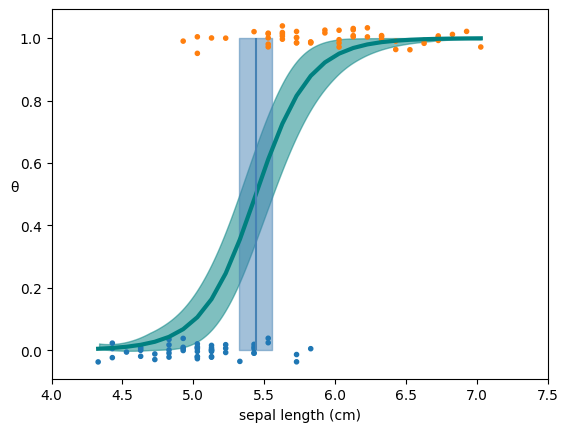

In [9]:
theta = trace_0['θ'].mean(axis=0)
idx = np.argsort(x_c)

# Plot the fitted theta
plt.plot(x_c[idx], theta[idx], color='teal', lw=3)
# Plot the HPD for the fitted theta
az.plot_hdi(x_c, trace_0['θ'], color='teal')
plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)

# Plot the decision boundary
plt.vlines(trace_0['bd'].mean(), 0, 1, color='steelblue')
# Plot the HPD for the decision boundary
bd_hpd = az.hdi(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='steelblue', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{y}' for y in y_0])

# use original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

## Multiple Logistic regression

The above example with a single feature can be extended to take **multiple features** or independent variables to separate the same two classes.

In [10]:
# Select the first two classes for a binary classification problem
df = iris_data.query("target == (0,1)")
y_0 = df.target
x_n = ['sepal length (cm)', 'sepal width (cm)']
# Center the data by subtracting the mean from both columns
df_c = df - df.mean() 
x_c = df_c[x_n].values

As we saw before, the equation for multiple logistic regression relating the $\theta$ parameter to the features can be written as

$$\theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2) $$

$$y ∼ Bern(\theta)$$

This gives us a decision boundary, assuming $y = 0.5$ is a reasonable boundary, of

$$x_2=− \frac{\alpha}{\beta_2}−\frac{\beta_1}{\beta_2} x_1$$

Unlike the previous equation, this one represents a line for the variables $x_1$ and $x_2$ which separates the two-dimensional space occupied by $x_1$ and $x_2$.
For higher dimensions, this decision boundary will be a hyperplane of dimension $‘n-1’$ for a feature space of dimension $‘n’$.

In [11]:
with pm.Model() as model_1: 
    α = pm.Normal('α', mu=0, sd=10) 
    β = pm.Normal('β', mu=0, sd=2, shape=len(x_n)) 
    μ = α + pm.math.dot(x_c, β) 
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ))) 
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_c[:,0])
    yl = pm.Bernoulli('yl', p=θ, observed=y_0) 
    trace_0 = pm.sample(2000)

/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


## Visualization 

We plot the HPD on the centered data, we have not scaled it back to the original range here.

/home/gretar/Git/LEARNING/Bayesian_Statistics/coursera__introduction_to_pymc/env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'sepal width (cm)')

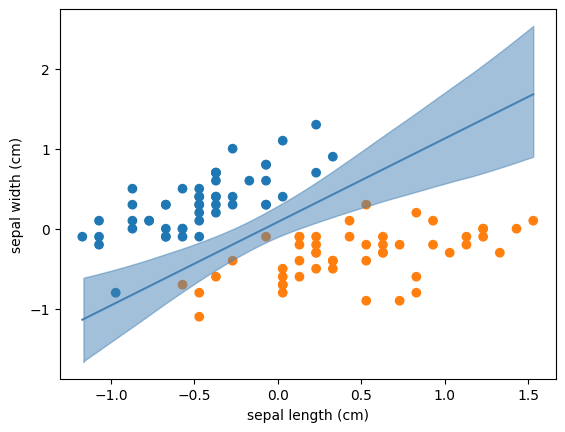

In [12]:
import arviz as az

idx = np.argsort(x_c[:,0]) 
bd = trace_0['bd'].mean(0)[idx] 
plt.scatter(x_c[:,0], x_c[:,1], c=[f'C{x}' for x in y_0]) 

plt.plot(x_c[:,0][idx], bd, color='steelblue');  # bd was the calculated decision boundary
az.plot_hdi(x_c[:,0], trace_0['bd'], color='steelblue') # Plot the HPD for the decision boundary

plt.xlabel(x_n[0]) 
plt.ylabel(x_n[1])

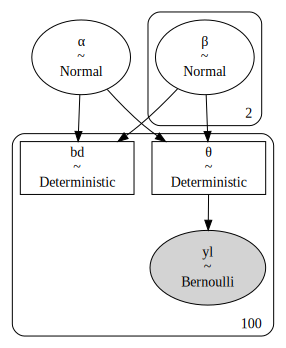

In [13]:
pm.model_to_graphviz(model_1)

# Multiclass Classification

If we have more than two classes this becomes a multiclass problem. In the case we use the softmax function instead of the sigmoid function. The sigmoid function is a special case of the softmax for a two-class classification problem.The softmax function can be written as: 

$$ softmax(x_i) = \frac{exp(x_i)}{\sum_k exp(x_k)} $$

Earlier, we also used a Bernoulli distribution as the likelihood for our $\theta$ paramater,  however now we sample from a categorical distribution.

$$\theta = softmax(\alpha + \beta x)$$
$$y∼Categorical(\theta)$$

In [14]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import pymc3 as pm
import numpy as np
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
df = datasets.load_iris()
iris_data = pd.DataFrame(df['data'], columns=df['feature_names'])
iris_data['target'] = df['target']
y_s = iris_data.target
x_n = iris_data.columns[:-1]
x_s = iris_data[x_n]
x_s = (x_s - x_s.mean()) / x_s.std()
x_s = x_s.values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


'0.98'

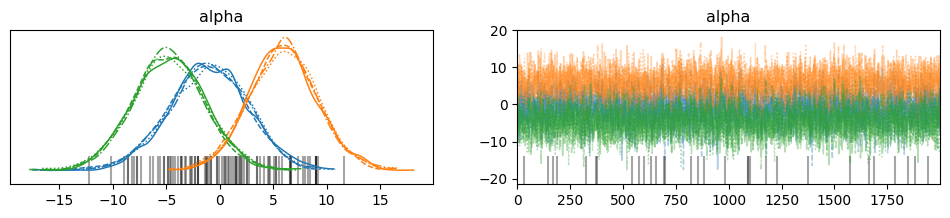

In [15]:
import theano as tt
tt.config.gcc.cxxflags = "-Wno-c++11-narrowing"

with pm.Model() as model_mclass:
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=3)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(4,3))
    μ = pm.Deterministic('μ', alpha + pm.math.dot(x_s, beta))
    θ = tt.tensor.nnet.softmax(μ)
    #θ = pm.math.exp(μ)/pm.math.sum(pm.math.exp(μ), axis=0)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000)

data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0) for point in data_pred]
az.plot_trace(trace_s, var_names=['alpha'])
f'{np.sum(y_s == np.argmax(y_pred, axis=1)) / len(y_s):.2f}'

# Inferring Rate Change with a Poisson Distribution

Discrete variables that represents count data can be handled using a Poisson distribution. The key element here is that it is the number of events happening in a given interval of time.

The event are suppose to be independent and the distribution is parameterized using a  single value called the rate parameter. This corresponds to and controls both mean and the variance of the distribution.

One implicatoin of this is that the higher the mean, the larger the variance of the distribution which can be a limitation for some phenomena. 

A higher value of the rate parameter indictes a higher likelihood of getting larger values from our distribution. It is represented by 

$$f(x) = e^{-\mu} \frac{\mu^x}{x!} $$

* The mean rate is represented by $\mu$.
* x is positive integer that represents the number of events that can happen.

If you recall from the discussion of the binomial distribution, that can also be used to model the probability of the number of successes out of 'n' trials. The Poission distribution is a special case of this binomial distribution and is used when the trials far exceed the number of successes.

## Poisson distribution investigation - [GaG extra]

A poission distribution is an example of a discrete distribution. If a random variable $Z$ has a Poisson distributions we donate this by writing $z = Poi(\lambda)$.

$$ p(z=k) = \frac{\lambda^k e^{- \lambda}}{k!} $$

$$ E[z|\lambda] = \lambda$$

**Higher values of $\lambda$ assigns more probability to larger outcomes. The variance of the distribution also increases with higer values of $\lambda$**



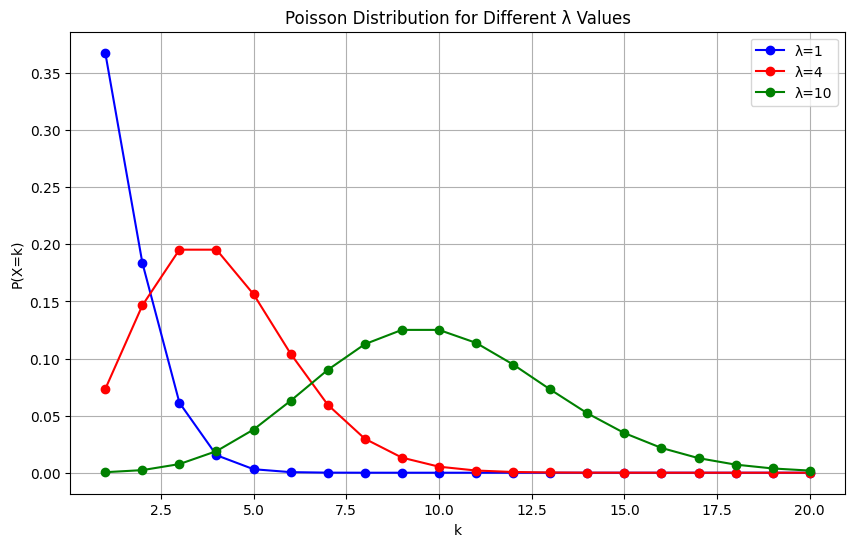

In [20]:
# Correcting the calculation for Poisson distribution
from scipy.stats import poisson

plt.figure(figsize=(10, 6))

lambdas = [1, 4, 10]
colors = ['blue', 'red', 'green']

x = [1, 2 ,3 ,4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for lam, color in zip(lambdas, colors):
    y = poisson.pmf(x, lam)
    plt.plot(x, y, marker='o', linestyle='-', color=color, label=f'λ={lam}')


plt.title('Poisson Distribution for Different λ Values')
plt.xlabel('k')
plt.ylabel('P(X=k)')
plt.legend()
plt.grid(True)
plt.show()


## Poisson Distribution Example

In the following example we look at a time-varying rate phenomena, consider the observations as the number of COVID-19 cases per day.
We observe cases for 140 days, however due to some interventional measures put in place it is suspected that the number of cases per day have gone down. If we assume that the number of cases can be modeled using a Poisson distribution, then this implies that there are two rates $\lambda_1$ and $\lambda_2$, and we can try to find where this rate-switch happens (time τ).

We don’t really know a lot about these rates, so we select a prior for both which can be from an Exponential, Gamma or Uniform distributions. Both the Exponential and Gamma distributions work better than the Uniform distribution since the Uniform distribution is the least informative. As usual, with enough observations one can even get away with a Uniform prior. Since we have no information regarding τ
, we select a Uniform prior distribution for that.

In the example below, try varying the following

1. Types of priors - a more informed prior is always better if this information is available.
2. The size of the data or the observations and the value of the theta parameter - more data results in better inference overall, the larger the difference in theta the easier to determine these rates.
3. The number of drawn samples - better and more accurate inference.
4. The number of chains - should reduce variance.
5. The number of cores - cores should be no more than the total number of chains and should be limited to the total number of cores on your hardware, you should see an increase in speed or decrease in runtime as you increase the number of cores.

Note that this uses the Metropolis algorithm since this is a discrete sampling problem.

Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 10 chains for 1_000 tune and 5_000 draw iterations (10_000 + 50_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'lambda_1'}>,
        <Axes: title={'center': 'lambda_1'}>],
       [<Axes: title={'center': 'lambda_2'}>,
        <Axes: title={'center': 'lambda_2'}>]], dtype=object)

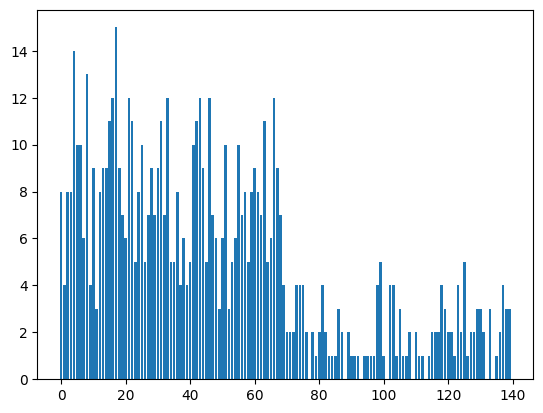

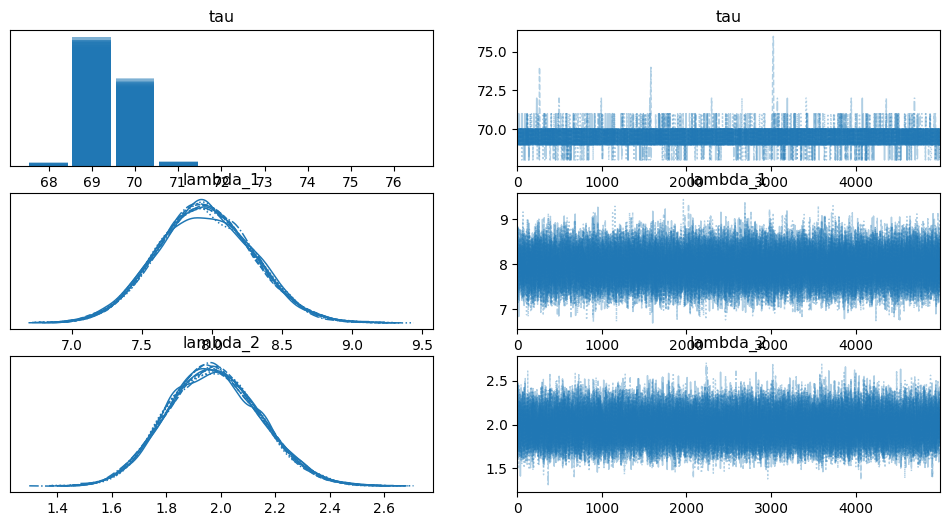

In [21]:
# ------------ Create the data ---------- #
n_1 = 70
θ_real_1 = 7.5
#ψ = 0.1
 # Simulate some data
counts_1 = np.random.poisson(θ_real_1,n_1)
#plt.bar(np.arange(len(counts_1)),counts_1)

n_2 = 70
θ_real_2 = 2.0
#ψ = 0.1
 # Simulate some data
counts_2 = np.random.poisson(θ_real_2,n_2)
#plt.bar(np.arange(len(counts_2)),counts_2)

total_data = np.concatenate((counts_1, counts_2))
n_counts = len(counts_1) + len(counts_2)
plt.figure()
plt.bar(np.arange(len(total_data)),total_data)

# ------------ Generate the model ----------- #

with pm.Model() as model_poisson:

    alpha_1 = 1.0 / counts_1.mean()
    alpha_2 = 1.0 / counts_2.mean()

    # Different priors have different results                     
    lambda_1 = pm.Exponential("lambda_1", alpha_1)
    lambda_2 = pm.Exponential("lambda_2", alpha_2) 
    #lambda_1 = pm.Gamma("lambda_1", 2, 0.1)
    #lambda_2 = pm.Gamma("lambda_2", 2, 0.1)
    #lambda_1 = pm.Uniform("lambda_1",lower=0, upper=5)
    
    # Uniform prior for the day since we have no information, if we do we should modify the prior to         
    # incorporate that information
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_counts - 1)
    idx = np.arange(n_counts) # id for the day
    lambda_c = pm.math.switch(tau > idx, lambda_1, lambda_2) # switch rate depending on the tau drawn

    observation = pm.Poisson("obs", lambda_c, observed=total_data)
    trace = pm.sample(5000, chains=10, cores=4)

az.plot_trace(trace)

### Visualize τ (tau)

We can use the ECDF (Empirical Cumulative Distribution Function) to visualize the distribution of τ.
The ECDF helps to visualize the distribution by plotting the CDF as opposed to the binning techniques used by a histogram. It also helps us to identify what values in the data are beneath a certain probability.

A reasonable scenario looks like the following:

Starting from day 1 till day ‘d’, it is expected that the rate parameter will be λ1, i.e with probability 100%.

On day ‘d’, it is possible that the rate is λ1 with probability ‘x’ which implies that the rate could be λ2 with probability ‘1 - x’. So this means that the distribution of τ has some probability mass on day ‘d’ indicating that the rate parameter switches to λ2 on this day.

For days after day ‘d’, the rate is λ2 with probability 100%.

Tau is  [70 70 69 ... 68 69 69]
Length of tau 50000
Lambda 1 is  [7.76691994 8.06113164 7.77520369 ... 7.42730017 7.78512717 8.57577807]
Length of Lambda 1  50000


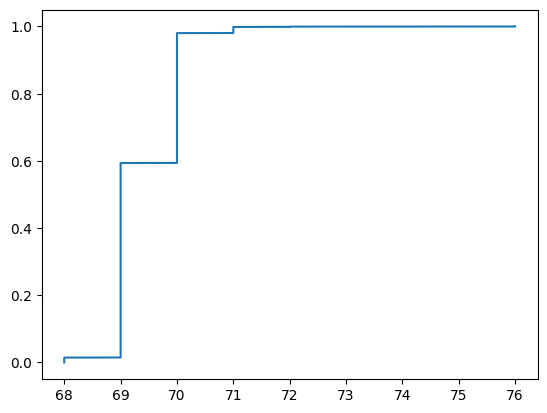

In [26]:
from statsmodels.distributions.empirical_distribution import ECDF

print('Tau is ',trace['tau'])
print("Length of tau", len(trace['tau']))
print('Lambda 1 is ',trace['lambda_1'])
print("Length of Lambda 1 ",len(trace['lambda_1']))
ecdf = ECDF(trace['tau'])
plt.plot(ecdf.x, ecdf.y, '-')

### Expected Value of Cases

For each draw of τ, there is a draw of λ1 and λ2. We can use the principles of Monte Carlo approximation to compute the expected value of COVID-19 cases on any day.

Expected value for day = $\frac{1}{N} \sum^{nsamples}_0$ Lambda_draw;

day > Tau_draw ? lambda_2_draw : lambda_1_draw 


* Draws are in combinations of (λ1,λ2,τ), we want to average out the λ value based on the proportion of λ suggestions as indicated by the samples

* For days 0,…68 we see that the probability of λ1 is 1 whereas the probability of λ2 is 0. So the expected value is just the average of all the λ1 samples.

* Similarly, for days from 72,… the probability of λ2 is 1 and the probability of λ1 is 0. So the expected value of λ is just the average of all the λ2 samples.

* For days in between - let us assume for day 69, we have 10% of the samples indicating that τ is 70 while 90% indicate that τ is 69.

* If τ is 70, that means that day 69 has rate λ1 but if τ is 69 that implies that day 69 has rate λ2 .

* The contribution to the expected value will 10% coming from sum(lambda_1_samples_that_have_tau_70) and 90% coming sum(lambda_2_samples_that_have_tau_69)

In [32]:
tau_samples = trace['tau']
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']

N = tau_samples.shape[0]
expected_values = np.zeros(n_counts)
for day in range(0, n_counts):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # For each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    expected_values[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

expected_values

array([7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.94771612, 7.94771612,
       7.94771612, 7.94771612, 7.94771612, 7.86189814, 4.39570147,
       2.09085416, 1.9832503 , 1.97741423, 1.97672055, 1.97574

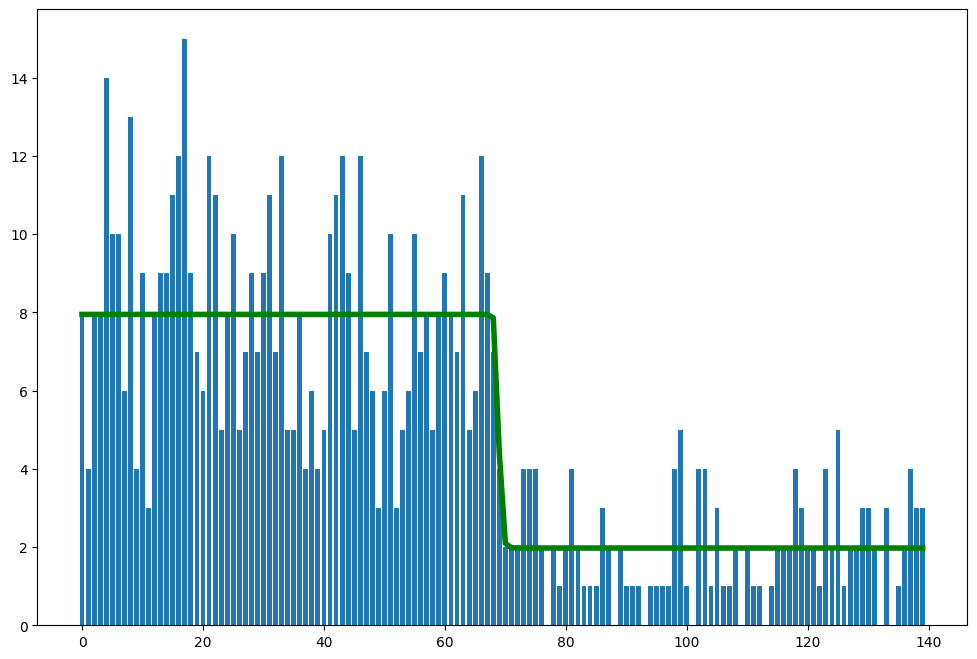

In [33]:
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(total_data)),total_data)
plt.plot(np.arange(n_counts), expected_values, color='g', lw='4')

In [31]:
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())

NameError: name 'lambda_1_samples' is not defined